# TP04 MapReduce - Multiplication Matricielle
# Matrice A et B chargées par lignes et colonnes

## Chargement des matrices A et B

In [11]:
import numpy as np
import time
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import re

## Chargement des fichiers lignes et colonnes

In [2]:
A_data = np.load("A.npz")
B_data = np.load("B.npz")

## Reconstruction de A et B à partir des lignes et colonnes

In [3]:
%%time
A = np.vstack([A_data[f"row_{i}"] for i in range(len(A_data.files))])
B = np.vstack([B_data[f"col_{j}"] for j in range(len(B_data.files))]).transpose()

CPU times: user 32.7 ms, sys: 8.12 ms, total: 40.8 ms
Wall time: 1.41 s


In [4]:
# Vérification des dimensions
print(f"Matrice A reconstruite : {A.shape}")
print(f"Matrice B reconstruite : {B.shape}")

Matrice A reconstruite : (100, 10000)
Matrice B reconstruite : (10000, 100)


## Multiplication avec NumPy

In [5]:
%time C = A @ B
print("Multiplication terminée avec succès.")

CPU times: user 52.1 ms, sys: 17 μs, total: 52.1 ms
Wall time: 51 ms
Multiplication terminée avec succès.


In [6]:
A = np.load("A.npy")
B = np.load("B.npy")

# Affichage des dimensions pour vérification
print(f"Matrice A : {A.shape}")
print(f"Matrice B : {B.shape}")

Matrice A : (100, 10000)
Matrice B : (10000, 100)


In [7]:
C_numpy = A @ B

## Questions

1. Ecrire un algorithme MapReduce qui calcule le produit matriciel de A et B en **multithreading** dans lequel chaque worker réalise le calcul d’un ou plusieurs $c_{ij}$ en ne chargeant que les lignes et les colonnes nécessaires.

In [19]:
def load_matrix(filename):
    """Charge les données du fichier NPZ sous forme de dictionnaire."""
    data = np.load(filename, allow_pickle=True)
    
    # Extraire le numéro de ligne/colonne à partir des clés (ex: "row_0" -> 0)
    matrix = {int(re.search(r'\d+', k).group()): v for k, v in data.items()}
    
    return matrix

def compute_cell(i, j, A_rows, B_cols):
    """Calcule un élément spécifique de la matrice résultat."""
    return i, j, np.dot(A_rows[i], B_cols[j])

def Produit_mt(A_file, B_file, num_workers=4):
    """Calcule le produit matriciel de A et B en parallèle."""
    A_rows = load_matrix(A_file)  # Dictionnaire {ligne: np.array}
    B_cols = load_matrix(B_file)  # Dictionnaire {colonne: np.array}
    
    rows = len(A_rows)
    cols = len(B_cols)
    
    C = np.zeros((rows, cols))  # Matrice résultat
    
    with ThreadPoolExecutor(max_workers=num_workers) as t_exe:
        futures = {t_exe.submit(compute_cell, i, j, A_rows, B_cols): (i, j) for i in range(rows) for j in range(cols)}
        
        for future in as_completed(futures):
            i, j, value = future.result()
            C[i, j] = value
    
    return C



In [20]:
%time C = Produit_mt("A.npz", "B.npz", num_workers=8)

CPU times: user 359 ms, sys: 25 ms, total: 384 ms
Wall time: 331 ms


2. Ecrire un algorithme MapReduce qui calcule le produit matriciel de A et B en **mutiprocessing** dans lequel chaque worker réalise le calcul d’un ou plusieurs $c_{ij}$ en ne chargeant que les lignes et les colonnes nécessaires.

In [15]:
def Produit_mp(A_file, B_file, num_workers=4):
    """Calcule le produit matriciel de A et B en parallèle."""
    A_rows = load_matrix(A_file)  # Dictionnaire {ligne: np.array}
    B_cols = load_matrix(B_file)  # Dictionnaire {colonne: np.array}
    
    rows = len(A_rows)
    cols = len(B_cols)
    
    C = np.zeros((rows, cols))  # Matrice résultat
    
    with ProcessPoolExecutor(max_workers=num_workers) as p_exe:
        futures = {p_exe.submit(compute_cell, i, j, A_rows, B_cols): (i, j) for i in range(rows) for j in range(cols)}
        
        for future in as_completed(futures):
            i, j, value = future.result()
            C[i, j] = value
    
    return C

In [16]:
%time C = Produit_mp("A.npz", "B.npz", num_workers=8)

CPU times: user 50.2 s, sys: 2min 42s, total: 3min 32s
Wall time: 5min 8s


3.Comparer les temps de restitution des différentes implémentations en variant le nombre de workers.

In [21]:
def measure_time(function, num_workers, A, B):
    tic = time.time()
    C = function(A, B, num_workers)
    toc = time.time()
    duration = toc-tic
    return duration

def compare_performance(A, B, worker_counts):
    mp_times = []
    mt_times = []
    
    for num_workers in worker_counts:
        mp_times.append(measure_time(Produit_mp, num_workers, A, B))
        mt_times.append(measure_time(Produit_mt, num_workers, A, B))
    
    plt.figure(figsize=(10, 5))
    plt.plot(worker_counts, mp_times, label='Multiprocessing', marker='o')
    plt.plot(worker_counts, mt_times, label='Multithreading', marker='s')
    plt.xlabel('Number of Workers')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Comparison of Execution Times')
    plt.legend()
    plt.grid()
    plt.show()

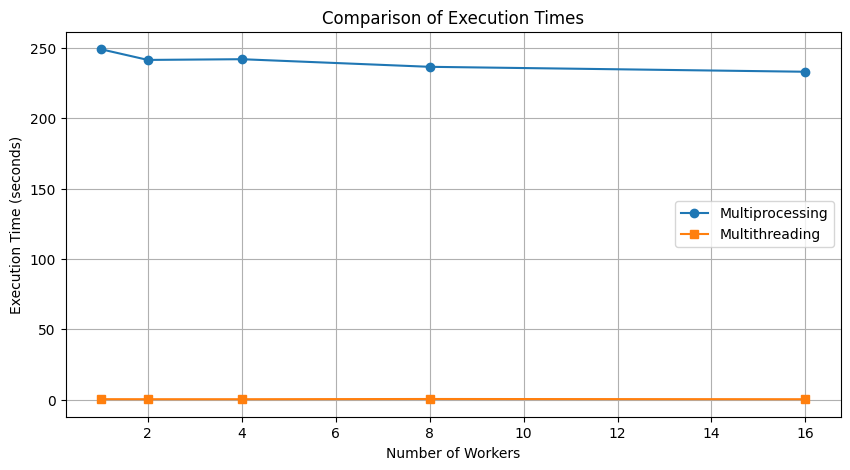

In [22]:
worker_counts = [1, 2, 4, 8, 16]
compare_performance("A.npz", "B.npz", worker_counts)